In [204]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas

In [205]:
df = pd.read_excel("./Biotech panel 1.xlsx", sheet_name = "PAD")
df.head()

,study ID,IL-33 (pg/ml),uPAR (pg/ml),CXCL6 (pg/ml),ESM-1 (pg/ml),SCF (pg/ml),TSG-14 (pg/ml),IL-2 (pg/ml),PCSK9 (pg/ml),RAGE (pg/ml),...,Plt,HbA1c,crp,HDL,Chol/ HDL ratio,LDL,non-HDL,glucose,glucose fasting,MRNno.
0,5,14.091162,557.896234,110.729424,1055.750683,116.074164,1333.413564,46.5159,69268.6,3231.556933,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,82783
1,14,33.331707,2383.453789,128.812424,472.920153,107.254642,570.205218,93.9765,66247.9,2459.595380,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,799525
2,92,19.413896,922.174636,207.177434,983.060117,69.369572,1452.355327,59.5806,117311,1455.813626,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2089217
3,119,59.897453,2734.344683,645.989311,1323.804448,187.559274,1353.296620,134.54,115404,4621.795653,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2736264
4,124,37.126933,4847.796709,268.216338,991.308486,140.609145,1423.928314,113.069,137419,2821.843801,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2028463


In [206]:

proteins = ['IL-33 (pg/ml)', 'uPAR (pg/ml)', 'CXCL6 (pg/ml)',
       'ESM-1 (pg/ml)', 'SCF (pg/ml)', 'TSG-14 (pg/ml)', 'IL-2 (pg/ml)',
       'PCSK9 (pg/ml)', 'RAGE (pg/ml)', 'CD62P (pg/ml)', 'ADAMTS13 (pg/ml)',
       'Tpo (pg/ml)', 'Tie-2 (pg/ml)', 'KIM-1 (pg/ml)', 'ICAM-1 (pg/ml)',
       'Angiopoietin-1 (pg/ml)', 'TNF RII (pg/ml)', 'TNF RI (pg/ml)',
       'BMP-2 (pg/ml)', 'ANGPTL3 (pg/ml)', 'ANGPTL4 (pg/ml)',
       'CD40 Ligand (pg/ml)', 'CD40 (pg/ml)', 'CXCL1 (pg/ml)']

cols = ['Study\nID','PAD dx', 'Stent', 'PAD intervention', 'MI', 'STROKE', 'LIMB LOSS',
       'Death', 'GFR', 'Age\n', 'Gender', 'Hypertension', 'Hyperchol',
       'Diabetes', 'Renal Insufficiency', 'Dialysis', 'Smoking Hx',
       'Congestive heart failure', 'Cornary artery disease', 'Stroke/TIA',
       'statin', 'ACEi/ARB', 'B-bl', 'CCB', 'HCTZ, Lasix', 'Insulin',
       'oral hypoglyc']

proteins_new = [s.rstrip("(pg/ml)").strip(" ") for s in proteins]

mapper = dict(zip(proteins, proteins_new))
mapper['Study\nID'] = "ID"
mapper['PAD dx'] = "hasPAD"
mapper['Age\n'] = "Age"

In [207]:
df = df[proteins + cols].rename(mapper, axis = 1)
df

,IL-33,uPAR,CXCL6,ESM-1,SCF,TSG-14,IL-2,PCSK9,RAGE,CD62P,...,Congestive heart failure,Cornary artery disease,Stroke/TIA,statin,ACEi/ARB,B-bl,CCB,"HCTZ, Lasix",Insulin,oral hypoglyc
0,14.091162,557.896234,110.729424,1055.750683,116.074164,1333.413564,46.5159,69268.6,3231.556933,19096.4,...,0,1,1,1,1.0,1.0,0.0,0.0,0.0,NaN
1,33.331707,2383.453789,128.812424,472.920153,107.254642,570.205218,93.9765,66247.9,2459.595380,35065.3,...,0,1,0,1,1.0,1.0,0.0,0.0,1.0,1.0
2,19.413896,922.174636,207.177434,983.060117,69.369572,1452.355327,59.5806,117311,1455.813626,31963.2,...,0,valuar disease,0,1,0.0,1.0,0.0,0.0,0.0,0.0
3,59.897453,2734.344683,645.989311,1323.804448,187.559274,1353.296620,134.54,115404,4621.795653,45794.4,...,0,1,0,1,1.0,1.0,1.0,1.0,0.0,0.0
4,37.126933,4847.796709,268.216338,991.308486,140.609145,1423.928314,113.069,137419,2821.843801,37232.2,...,0,1,0,1,1.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456,19.293624,1306.375275,199.662280,659.703232,189.360352,1815.919962,37.0922,1.12191e+06,2789.363327,26758.3,...,0,0,1,1,1.0,0.0,0.0,0.0,0.0,0.0
457,43.199200,2934.660140,306.064934,471.722845,168.013810,694.179316,148.353,126526,2938.617351,57921.4,...,0,1,0,1,1.0,1.0,0.0,0.0,0.0,1.0
458,18.041236,1539.144696,177.358173,307.041612,76.732167,1317.496045,45.6247,106692,1990.947935,28926,...,0,1,0,1,1.0,0.0,1.0,0.0,0.0,0.0
459,22.852870,1420.162225,205.667451,773.600491,183.812321,1725.312706,53.2449,528302,2364.294969,27916,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Output - Diagnosis of PAD

In [208]:
df["hasPAD"] = df.hasPAD.apply(lambda x: int(x.lower() == 'pad'))
df.hasPAD.value_counts(dropna=False)

1    295
0    166
Name: hasPAD, dtype: int64

In [209]:
df.select_dtypes("object").columns

Index(['IL-2', 'PCSK9', 'CD62P', 'KIM-1', 'Angiopoietin-1', 'TNF RII', 'BMP-2',
       'ANGPTL3', 'CXCL1', 'Stent', 'PAD intervention', 'MI', 'STROKE',
       'LIMB LOSS', 'Death', 'GFR', 'Hypertension', 'Congestive heart failure',
       'Cornary artery disease', 'Stroke/TIA', 'statin'],
      dtype='object')

In [210]:
###proteins should be numerical,,removing any leading or trailing chars
p_cols = ['IL-2', 'PCSK9', 'CD62P', 'KIM-1', 'Angiopoietin-1', 'TNF RII', 'BMP-2',
       'ANGPTL3', 'CXCL1']
df[p_cols] = df[p_cols].apply(lambda col: col.astype(str).str.strip(",<>").astype("float64"), axis = 0)

In [211]:
df.select_dtypes("object").columns

Index(['Stent', 'PAD intervention', 'MI', 'STROKE', 'LIMB LOSS', 'Death',
       'GFR', 'Hypertension', 'Congestive heart failure',
       'Cornary artery disease', 'Stroke/TIA', 'statin'],
      dtype='object')

## PAD Complication vars

> Columns 'Stent' to 'GFR' are complications variables for the stage 2 of project

In [212]:
#df.Stent.value_counts()

## Clinical Variables

Some variables have unwanted levels -- turn them into binary variables for modeling

In [213]:
###these are the clinical history vars
df.iloc[:,df.columns.get_loc("Age"):].dtypes

Age                         float64
Gender                      float64
Hypertension                 object
Hyperchol                   float64
Diabetes                    float64
Renal Insufficiency         float64
Dialysis                    float64
Smoking Hx                  float64
Congestive heart failure     object
Cornary artery disease       object
Stroke/TIA                   object
statin                       object
ACEi/ARB                    float64
B-bl                        float64
CCB                         float64
HCTZ, Lasix                 float64
Insulin                     float64
oral hypoglyc               float64
dtype: object

In [214]:
obj_cols = df.iloc[:,df.columns.get_loc("Age"):].select_dtypes("object").columns
df[obj_cols] = df[obj_cols].astype(str) 
df[obj_cols] = df[obj_cols].apply(lambda col: col.str.strip()) #remove possible spaces
df[obj_cols].apply(lambda x: pd.value_counts(x, dropna = False))

df = df.replace(to_replace={"Hypertension": {"CHECK": np.nan},
"Congestive heart failure": {"1 (In past)": "1"},
"Cornary artery disease": {"valuar disease": "1"},
"Stroke/TIA": {"tia": "1"},
"statin": {"2": "1", "check": np.nan}
})

df[obj_cols] = df[obj_cols].astype(float)

In [215]:
df[obj_cols].apply(lambda x: pd.value_counts(x, dropna=False))

,Hypertension,Congestive heart failure,Cornary artery disease,Stroke/TIA,statin
0.0,108,434,285,365,89
1.0,350,21,169,78,345
NaN,3,6,7,18,27


In [216]:
df.shape

(461, 51)

## ADD new proteins from panel 3

In [221]:
newPanel = pd.read_excel("./panel 3.xlsx", sheet_name="pad n")
new_panel_proteins = ['NT- pro BNP (pg/ml)', 'Ck-MB (pg/ml)', 'Troponin I (pg/ml)',
    'FABP4  (pg/ml)', 'FABP3 1value (pg/ml) baseline', 'Cathepsin S',
    'APRIL/TNFSF13', 'Galectin-1', 'ALCAM/CD166', 'EpCAM/TROP1', 'Furin',
    'GDF-15', 'Chemerin', 'Endostatin', 'Aggrecan']
newPanel = newPanel[['study ID'] + new_panel_proteins].copy()
newPanel.rename(columns={"study ID": 'ID'}, inplace=True)


In [218]:
df = df.merge(newPanel, on="ID", how="left")

# Exploratory Data Analysis

In [223]:
df.shape

(461, 67)

In [222]:
df[proteins_new + new_panel_proteins].isna().sum().sort_values(ascending=False)

FABP4  (pg/ml)                   70
FABP3 1value (pg/ml) baseline    47
NT- pro BNP (pg/ml)              46
Ck-MB (pg/ml)                    46
Troponin I (pg/ml)               46
Cathepsin S                      29
Chemerin                         25
ALCAM/CD166                      24
APRIL/TNFSF13                    23
Aggrecan                         21
Galectin-1                       20
Endostatin                       19
CXCL1                            18
Furin                            17
GDF-15                           17
EpCAM/TROP1                      17
uPAR                             15
SCF                              15
TSG-14                           14
TNF RII                          13
ADAMTS13                         12
Tpo                               9
RAGE                              7
CXCL6                             0
ESM-1                             0
IL-2                              0
PCSK9                             0
CD62P                       

In [123]:
df.shape

(461, 51)

In [122]:
df[proteins_new].dropna().shape

(384, 24)

In [121]:
df[proteins_new + ["hasPAD"]].groupby("hasPAD").describe().T

hasPAD                0            1
IL-33 count  166.000000   295.000000
      mean    26.955637    27.225852
      std     31.667780    15.320735
      min      6.952810     4.451161
      25%     16.981160    18.041236
...                 ...          ...
CXCL1 min      4.086812    93.139045
      25%    152.018053   164.736383
      50%    215.142341   223.944663
      75%    258.036824   276.666994
      max    929.030578  2060.370359

[192 rows x 2 columns]

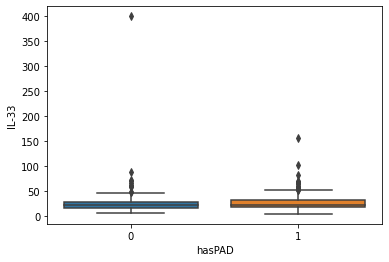

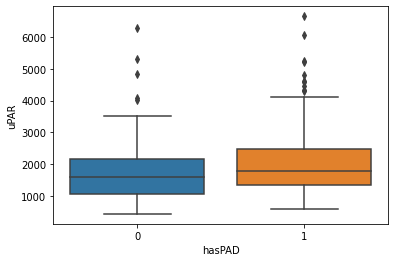

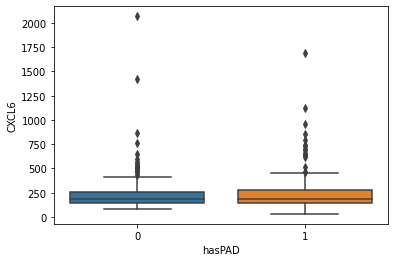

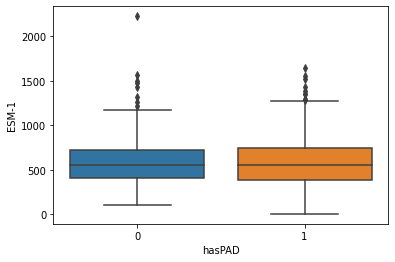

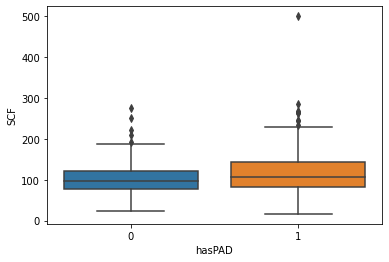

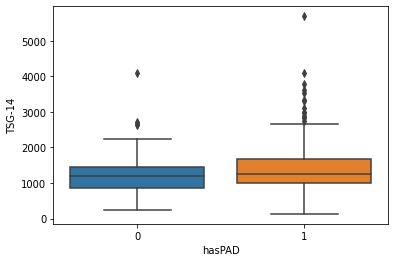

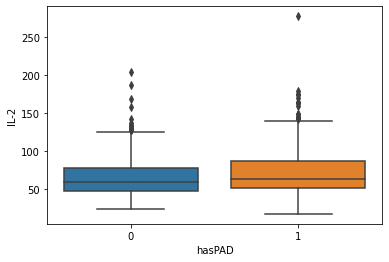

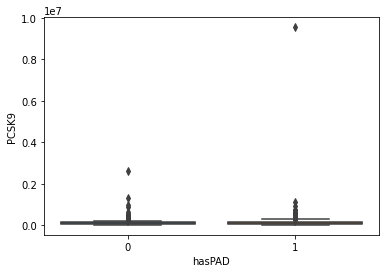

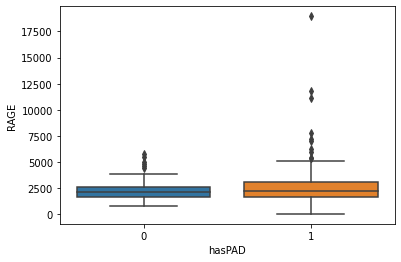

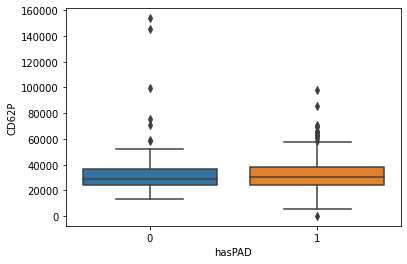

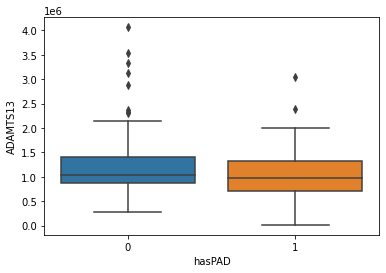

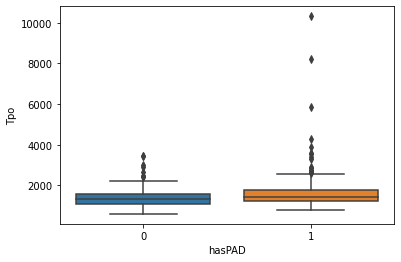

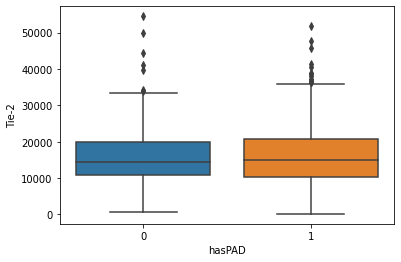

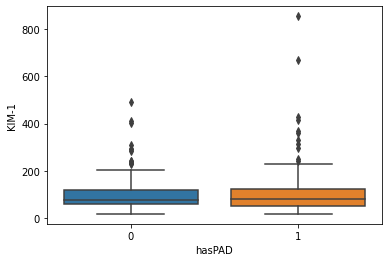

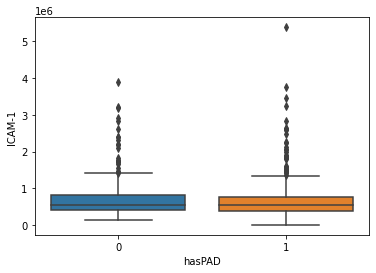

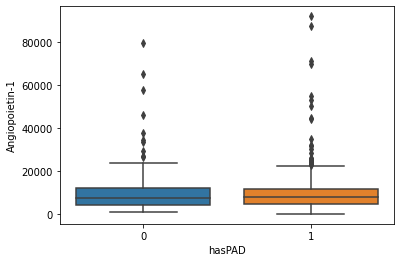

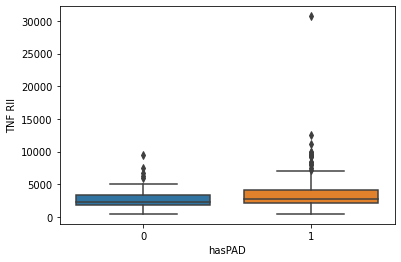

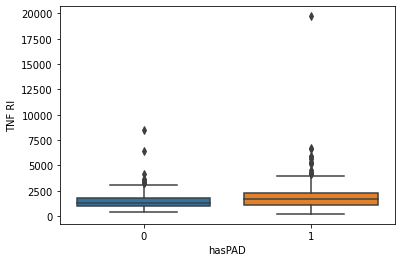

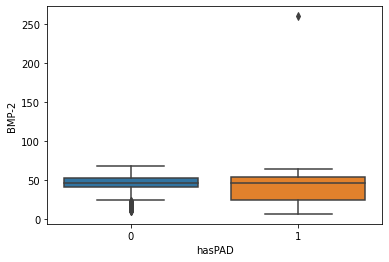

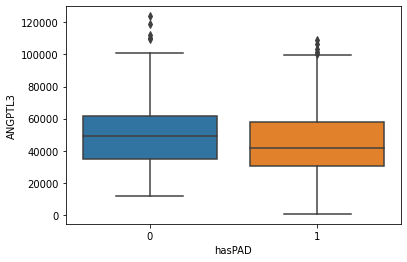

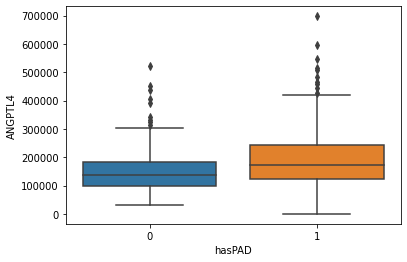

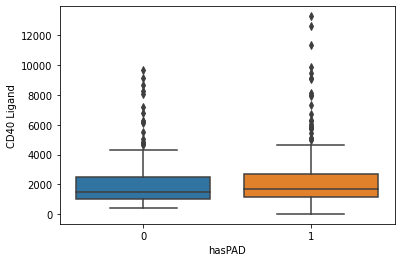

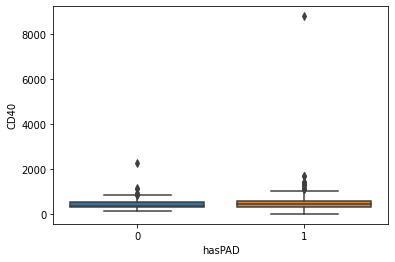

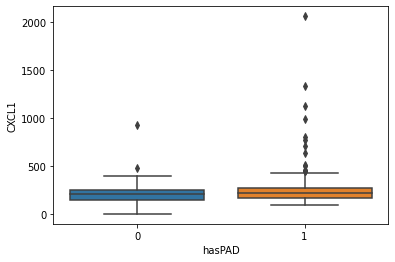

In [98]:
# for var in proteins_new:
#     sns.boxplot(data= df, y = var, x="hasPAD")
#     plt.show()

In [99]:
df.hasPAD.value_counts()

1    295
0    166
Name: hasPAD, dtype: int64

In [105]:
from scipy.stats import ttest_ind, levene, welch

df_test = df[proteins_new + ["hasPAD"]]
# df_test.groupby("hasPAD").apply(lambda t_test: ttest_ind(df_test[]))

In [119]:
df_test = df[proteins_new + ["hasPAD"]].dropna()
print(df_test.shape)
for protein in proteins_new:
    grp1 = df_test.loc[df_test.hasPAD == 1, protein]
    grp2 = df_test.loc[df_test.hasPAD == 0, protein]
    print("Protein {} has variance test p-value: {:.2f} ".format(protein, levene(grp1, grp2)[1]))

(384, 25)
Protein IL-33 has variance test p-value: 0.13 
Protein uPAR has variance test p-value: 0.15 
Protein CXCL6 has variance test p-value: 0.99 
Protein ESM-1 has variance test p-value: 0.17 
Protein SCF has variance test p-value: 0.01 
Protein TSG-14 has variance test p-value: 0.02 
Protein IL-2 has variance test p-value: 0.20 
Protein PCSK9 has variance test p-value: 0.58 
Protein RAGE has variance test p-value: 0.00 
Protein CD62P has variance test p-value: 0.09 
Protein ADAMTS13 has variance test p-value: 0.76 
Protein Tpo has variance test p-value: 0.15 
Protein Tie-2 has variance test p-value: 0.00 
Protein KIM-1 has variance test p-value: 0.20 
Protein ICAM-1 has variance test p-value: 0.97 
Protein Angiopoietin-1 has variance test p-value: 0.21 
Protein TNF RII has variance test p-value: 0.01 
Protein TNF RI has variance test p-value: 0.00 
Protein BMP-2 has variance test p-value: 0.02 
Protein ANGPTL3 has variance test p-value: 0.58 
Protein ANGPTL4 has variance test p-va

In [114]:
levene(grp1, grp2)[0]

1.551482486511522